In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

import warnings
# Suppress specific warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Financial Assistance - Copy.csv', parse_dates=['Date'], dayfirst=True)

In [3]:
df

,Date,CEFA
0,2018-02-01,1890
1,2018-10-01,1798
2,2019-02-01,1918
3,2019-10-01,1833
4,2020-02-01,1915
5,2020-10-01,4620
6,2021-02-01,4160
7,2021-10-01,6666
8,2022-02-01,6141
9,2022-10-01,7046


In [4]:
df.set_index('Date', inplace=True)

In [5]:
df

,CEFA
Date,
2018-02-01,1890
2018-10-01,1798
2019-02-01,1918
2019-10-01,1833
2020-02-01,1915
2020-10-01,4620
2021-02-01,4160
2021-10-01,6666
2022-02-01,6141


In [6]:
df

,CEFA
Date,
2018-02-01,1890
2018-10-01,1798
2019-02-01,1918
2019-10-01,1833
2020-02-01,1915
2020-10-01,4620
2021-02-01,4160
2021-10-01,6666
2022-02-01,6141


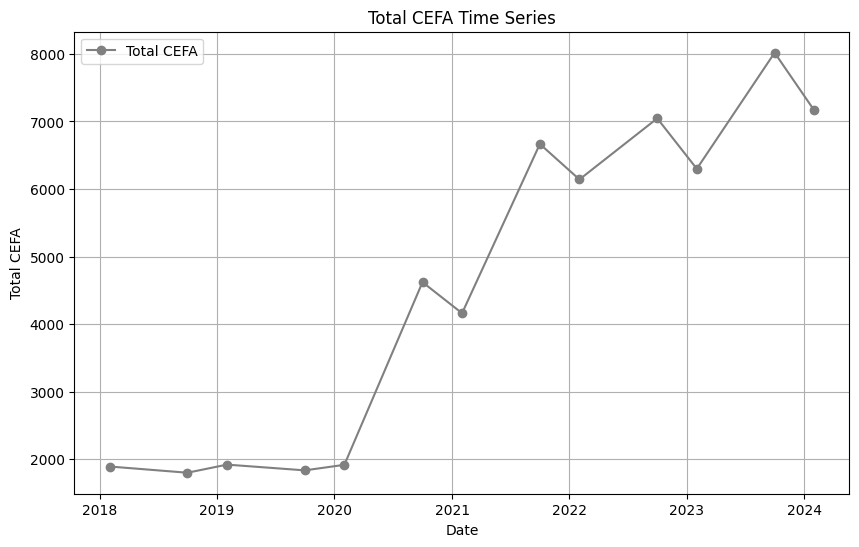

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['CEFA'], label='Total CEFA', marker='o', color='gray')
plt.xlabel('Date')
plt.ylabel('Total CEFA')
plt.title('Total CEFA Time Series')
plt.legend()
plt.grid()
plt.show()

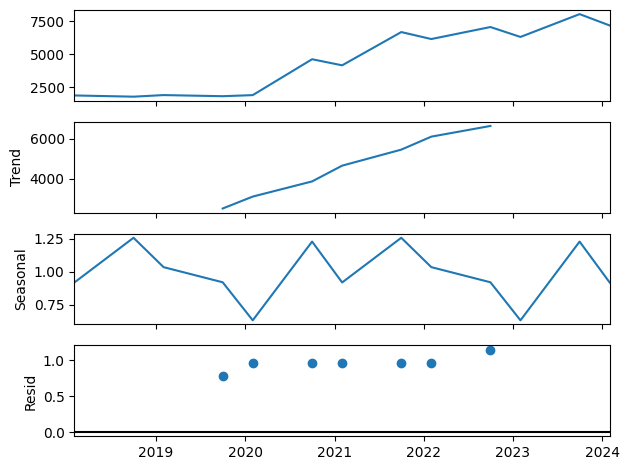

In [13]:
result = seasonal_decompose(df, model='multiplicative', period=6)
result.plot()
pyplot.show()

There's a half a year seasonality within the data, hence, we are going to use SARIMAX, a variant of ARIMA that is best for data with seasonality

# Model Identification

The first step in developing a Box-Jenkins model is to determine if the series is stationary and if there is any significant seasonality that needs to be modeled.

Reference: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc446.htm

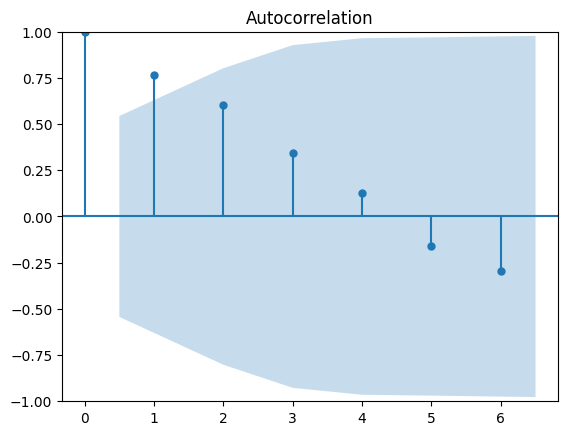

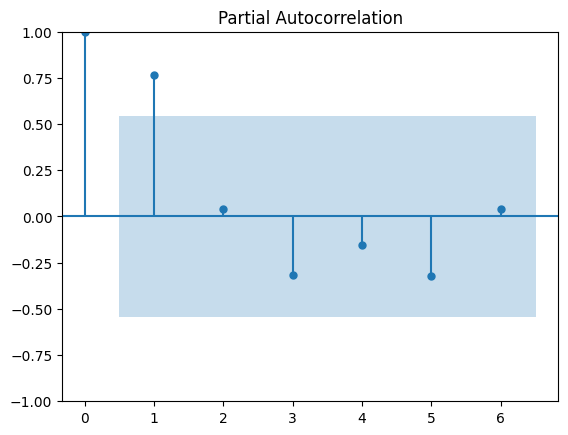

In [14]:
collegeACF = plot_acf(df)
collegePACF = plot_pacf(df)

The PACF plot shows a significant spike at lag 1 and a drop-off afterwards. This suggests that an AR(1) process might fit well. The ACF plot shows a gradual decline, which suggests the presence of a moving average component, likely MA(1) or MA(2), as the autocorrelation dies off after a couple of lags. There are no clear signs of non-stationarity (e.g., no slow decay in the ACF), suggesting that the series may not need differencing (i.e., I=0). 

To check further, Augmented Dickey-Fuller Test is to be done using the data


**Pointers**
* Autocorrelation plots (Box and Jenkins, pp. 28-32) are a commonly-used tool for checking randomness in a data set. This randomness is ascertained by computing autocorrelations for data values at varying time lags. If random, such autocorrelations should be near zero for any and all time-lag separations. If non-random, then one or more of the autocorrelations will be significantly non-zero. Reference: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.html
* The shaded blue area represents the confidence interval (95%). Any points outside this shaded area indicate significant autocorrelation
* Y-Axis (Autocorrelation): This axis shows the autocorrelation coefficients, which measure the correlation between the time series and its lagged values.
* X-Axis (Lag): This axis represents the lag number, which is the number of time steps by which the series is shifted. For example, a lag of 1 compares the series with itself offset by one time period.
* Confidence Bands: The dashed lines (usually set around ±1.96/√n, where n is the sample size) indicate the confidence intervals. If the autocorrelation values (bars) are within these bands, they are not statistically significant, meaning there is no strong correlation at that lag.

**Pointers for ADF Test**
* Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series.
* The ADF test belongs to a category of tests called ‘Unit Root Test’, which is the proper method for testing the stationarity of a time series. Unit root is a characteristic of a time series that makes it non-stationary. Technically speaking, a unit root is said to exist in a time series of the value of alpha = 1. Unit Root in Data? Non-Stationary
* A Dickey-Fuller test is a unit root test that tests the null hypothesis that α=1 in the following model equation. alpha is the coefficient of the first lag on Y. The ADF test expands the Dickey-Fuller test equation to include high order regressive process in the model.
* Since the null hypothesis assumes the presence of unit root, that is α=1, the p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

Reference: https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/

In [16]:
# Null Hypothesis: There is a unit root in the data. The data is non-stationary
# Alternative Hypothesis: There is no unit root in the data. The data is stationary

result = adfuller(df['CEFA'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.28991494169045523
p-value: 0.9269205830954261


P-value is significantly higher than the typical threshold of 0.05 and the ADF statistic is less negative than all the critical values. We failed to reject the Null Hypothesis, therefore, the data is non-stationary.. To proceed, the data needs differencing to make it stationary

In [20]:
data_diff = df['CEFA'].diff().dropna()

# ADF test
result = adfuller(data_diff)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -8.465528287574045
p-value: 1.5261990167693613e-13


P-value is now less than 0.05 after first oreder of differencing, hence, we will proceed with I(1).

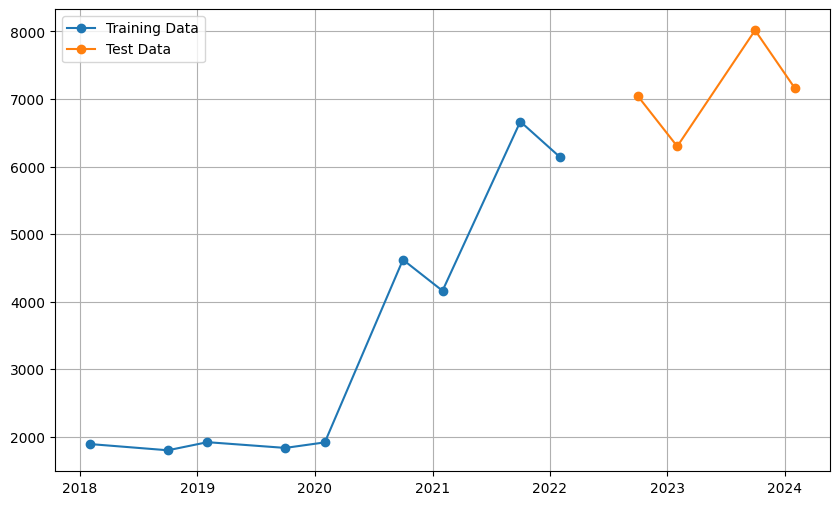

In [29]:
trainSize = int(len(df) * 0.7)
train, test = df['CEFA'][:trainSize], df['CEFA'][trainSize:]

plt.figure(figsize=(10,6))
plt.plot(train, label='Training Data', marker='o')
plt.plot(test, label='Test Data', marker='o')
plt.legend()
plt.grid()
plt.show()

In [30]:
train

Date
2018-02-01    1890
2018-10-01    1798
2019-02-01    1918
2019-10-01    1833
2020-02-01    1915
2020-10-01    4620
2021-02-01    4160
2021-10-01    6666
2022-02-01    6141
Name: CEFA, dtype: int64

Now, check for the seasonality of the data and possible parameters for the seasonal model.

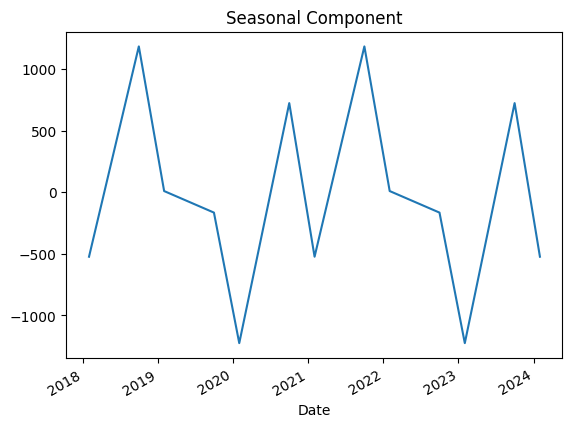

In [32]:
df.index = pd.to_datetime(df.index)
decomposition = seasonal_decompose(df['CEFA'], model='additive', period=6)
decomposition.seasonal.plot(title='Seasonal Component')
plt.show()

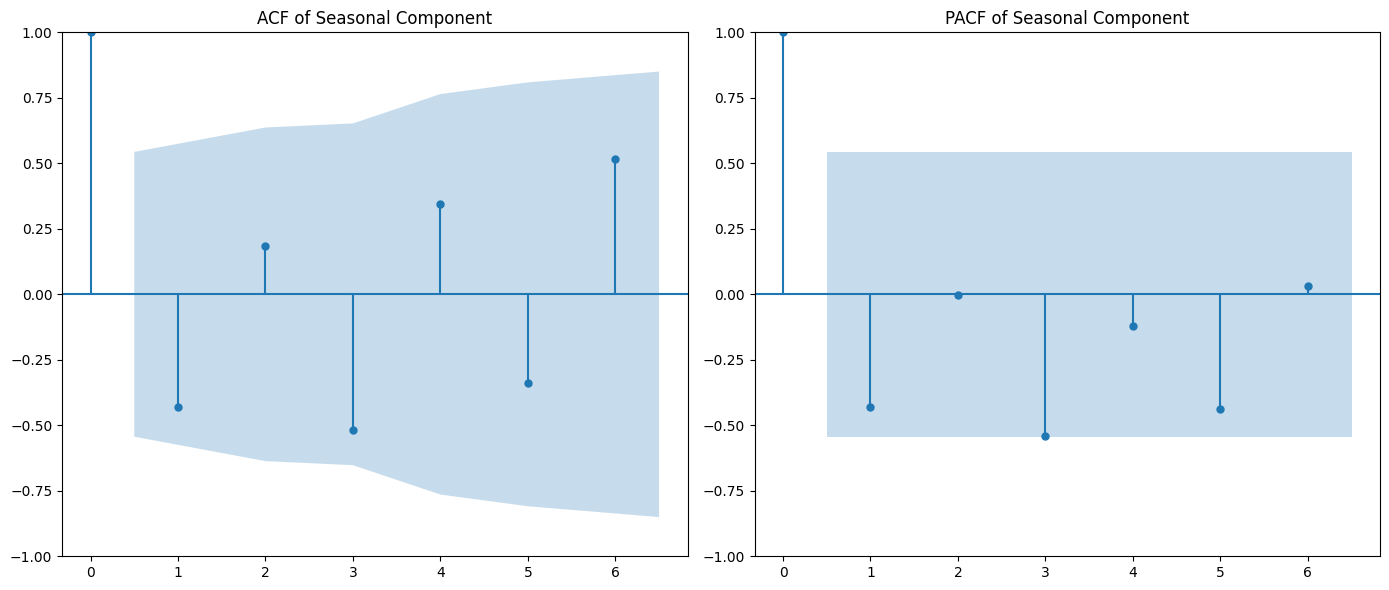

In [33]:
plt.figure(figsize=(14, 6))

plt.subplot(121)
plot_acf(decomposition.seasonal.dropna(), lags=6, ax=plt.gca())
plt.title('ACF of Seasonal Component')

plt.subplot(122)
plot_pacf(decomposition.seasonal.dropna(), lags=6, ax=plt.gca())
plt.title('PACF of Seasonal Component')

plt.tight_layout()
plt.show()

The PACF shows a significant spike at lag 1 and very small correlations afterward. This suggests a seasonal autoregressive component (SAR) of order 1 (SAR(1)). The ACF shows alternating positive and negative spikes, indicating the presence of a seasonal moving average (SMA) component. The magnitude of these spikes suggests an SMA(1) model could be appropriate.

In [34]:
result = adfuller(decomposition.seasonal.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -142758152428626.72
p-value: 0.0


The ADF Statistic is extremely negative, which is a strong indication that the seasonal component is stationary. The p-value is 0.0, which means we reject the null hypothesis that the data has a unit root (i.e., it's non-stationary).

In [44]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 1, 0, 6), enforce_stationarity=True)

results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               CEFA   No. Observations:                    9
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 6)   Log Likelihood                 -17.135
Date:                            Tue, 17 Sep 2024   AIC                             40.271
Time:                                    21:02:33   BIC                             36.350
Sample:                                         0   HQIC                            32.072
                                              - 9                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7380   3.19e+04  -2.32e-05      1.000   -6.24e+04    6.24e+04
ma.L1          0.1661   6.23e+04   

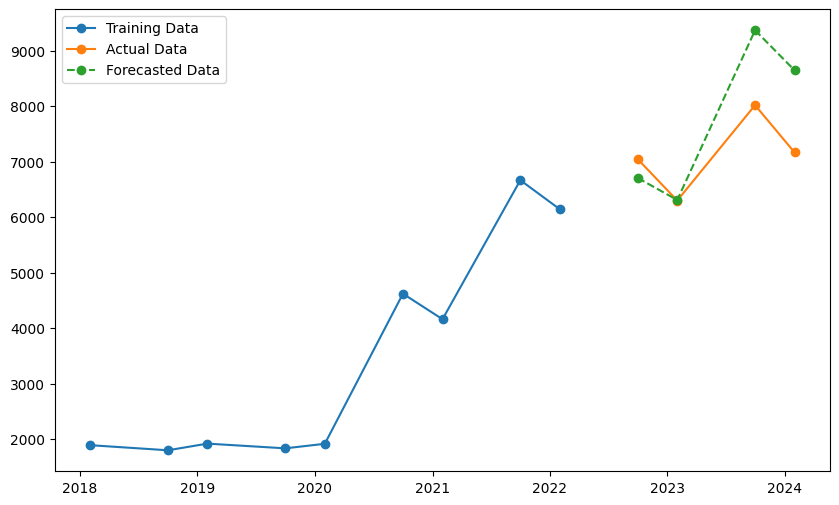

Root Mean Squared Error: 1016.2864347008464


In [45]:
forecast = results.forecast(steps=len(test))

plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Training Data', marker='o')
plt.plot(test.index, test, label='Actual Data', marker='o')
plt.plot(test.index, forecast, label='Forecasted Data', linestyle='--', marker='o')
plt.legend()
plt.show()

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

forecast_df = pd.DataFrame(forecast, index=test.index, columns=['Forecast'])

In [49]:
forecast.index = test.index

model_result = pd.DataFrame({
    'Actual': test,
    'Forecast': forecast
})
model_result['Difference'] = model_result['Actual'] - model_result['Forecast']

mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)

print(model_result)
print(" ")
print(f'Root Mean Squared Error: {rmse}')


            Actual     Forecast   Difference
Date                                        
2022-10-01    7046  6706.563719   339.436281
2023-02-01    6299  6308.431421    -9.431421
2023-10-01    8018  9367.781067 -1349.781067
2024-02-01    7165  8646.262164 -1481.262164
 
Root Mean Squared Error: 1016.2864347008464


In [64]:
# Null Hypothesis: The residuals are independently distributed.
# Alternative Hypothesis: The residuals are not independently distributed; they exhibit serial correlation.
sm.stats.acorr_ljungbox(results.resid, lags=[8], return_df=True)

,lb_stat,lb_pvalue
8,5.066454,0.75045


The p-value is well above the common significance level (0.05). This indicates that we cannot reject the null hypothesis, which means the residuals do not show significant autocorrelation suggesting that your model's residuals are close to white noise and the model is likely well-specified.

Reference: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc44a.htm

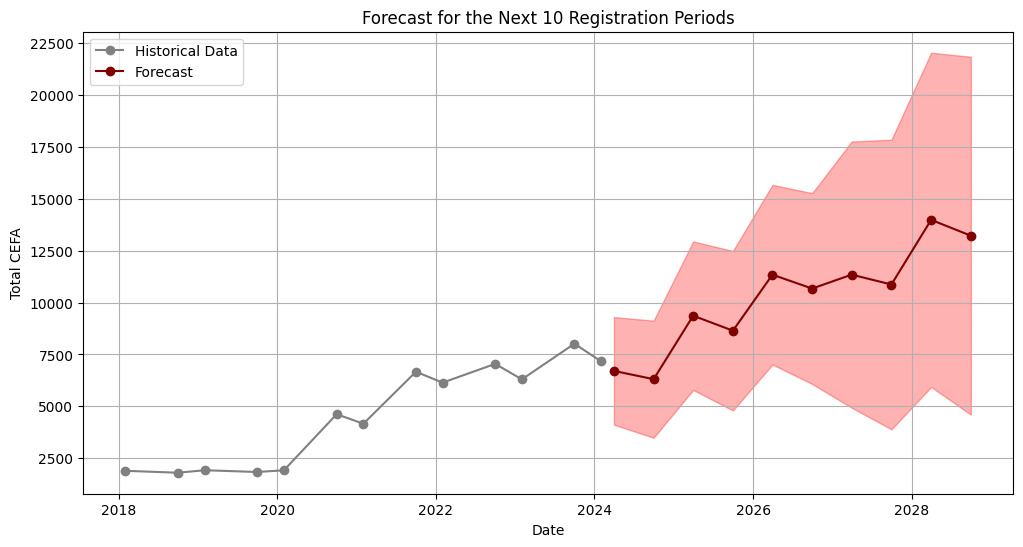

In [65]:
forecast_steps = 10
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='6M')
forecast_mean = forecast.predicted_mean
forecast_mean.index = forecast_index

# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['CEFA'], label='Historical Data', marker='o', color='gray')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='maroon', marker='o')
plt.fill_between(forecast_mean.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='red', alpha=0.3)
plt.title('Forecast for the Next 10 Registration Periods')
plt.xlabel('Date')
plt.ylabel('Total CEFA')
plt.legend()
plt.grid()
plt.show()

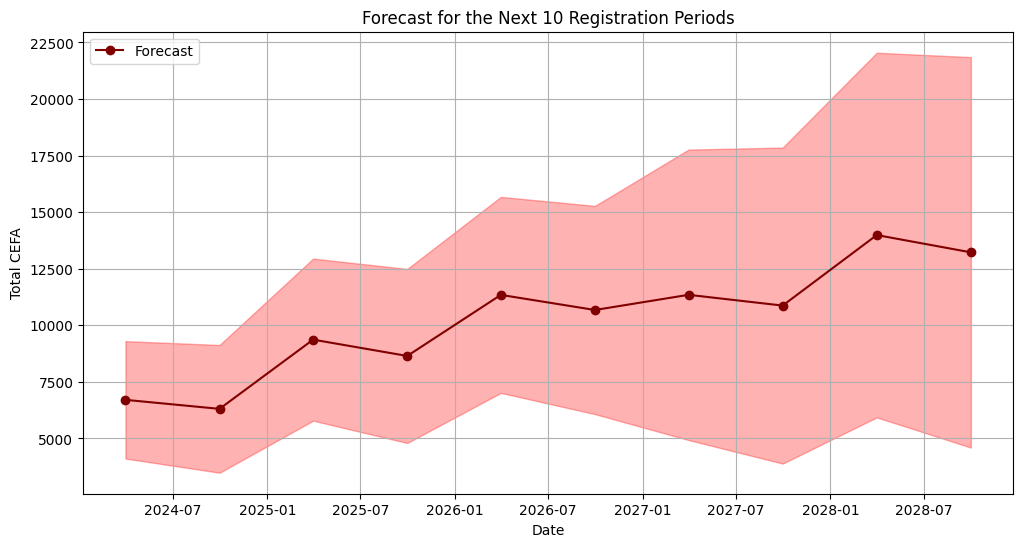

In [66]:
# Plot historical data and forecast
plt.figure(figsize=(12, 6))
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='maroon', marker='o')
plt.fill_between(forecast_mean.index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='red', alpha=0.3)
plt.title('Forecast for the Next 10 Registration Periods')
plt.xlabel('Date')
plt.ylabel('Total CEFA')
plt.legend()
plt.grid()
plt.show()